### Dataset Dolar - Janela Somente da Cotação

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_predict
from skopt import BayesSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

# Carregar os dados
file_path = "Dataset_Dolar.csv"
df = pd.read_csv(file_path)
df = df[['t', 'ano', 'mes', 'cotacao', 'ipca_acumulado', 'cpi', 'selic',
       'divida_pp', 'fed_rate']]
# Criar novas features (médias móveis e desvio padrão)
for shift_val in range(1,4):
    for column in ['cotacao', 'ipca_acumulado', 'cpi', 'selic',
           'divida_pp', 'fed_rate']:
        column_name = column + f'_{str(shift_val)}'
        df[column_name] = df[column].shift(shift_val)
        df.fillna(df[column].values[0], inplace=True)  # Lidar com NaNs no início
display(df)

,t,ano,mes,cotacao,ipca_acumulado,cpi,selic,divida_pp,fed_rate,cotacao_1,...,cpi_2,selic_2,divida_pp_2,fed_rate_2,cotacao_3,ipca_acumulado_3,cpi_3,selic_3,divida_pp_3,fed_rate_3
0,1,2000,1,1.7840,9.22,169.300,18.937619,51.27,5.45,1.7840,...,169.300,18.937619,51.27,5.45,1.7840,9.22,169.300,18.937619,51.27,5.45
1,2,2000,2,1.7680,9.35,170.000,18.869524,51.27,5.73,1.7840,...,169.300,18.937619,51.27,5.45,1.7840,9.22,169.300,18.937619,51.27,5.45
2,3,2000,3,1.7395,9.57,171.000,18.846667,51.27,5.85,1.7680,...,169.300,18.937619,51.27,5.45,1.7840,9.22,169.300,18.937619,51.27,5.45
3,4,2000,4,1.8050,9.99,170.900,18.618421,51.27,6.02,1.7395,...,170.000,18.869524,51.27,5.73,1.7840,9.22,169.300,18.937619,51.27,5.45
4,5,2000,5,1.8240,10.00,171.200,18.512727,51.27,6.27,1.8050,...,171.000,18.846667,51.27,5.85,1.7680,9.35,170.000,18.869524,51.27,5.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,295,2024,7,5.6500,157.05,313.534,10.400000,77.44,5.33,5.5925,...,313.225,10.459524,75.81,5.33,5.1934,156.00,313.207,10.650000,75.26,5.33
295,296,2024,8,5.6103,157.03,314.121,10.400000,77.65,5.33,5.6500,...,313.049,10.400000,76.85,5.33,5.2443,156.46,313.225,10.459524,75.81,5.33
296,297,2024,9,5.4482,157.47,314.686,10.495238,77.44,5.13,5.6103,...,313.534,10.400000,77.44,5.33,5.5925,156.67,313.049,10.400000,76.85,5.33
297,298,2024,10,5.7867,158.03,315.454,10.650000,77.75,4.83,5.4482,...,314.121,10.400000,77.65,5.33,5.6500,157.05,313.534,10.400000,77.44,5.33


In [17]:
df.drop(columns=['t', 'ano', 'mes', 'cotacao', 'ipca_acumulado', 'cpi', 'selic',
       'divida_pp', 'fed_rate'])

,cotacao_1,ipca_acumulado_1,cpi_1,selic_1,divida_pp_1,fed_rate_1,cotacao_2,ipca_acumulado_2,cpi_2,selic_2,divida_pp_2,fed_rate_2,cotacao_3,ipca_acumulado_3,cpi_3,selic_3,divida_pp_3,fed_rate_3
0,1.7840,9.22,169.300,18.937619,51.27,5.45,1.7840,9.22,169.300,18.937619,51.27,5.45,1.7840,9.22,169.300,18.937619,51.27,5.45
1,1.7840,9.22,169.300,18.937619,51.27,5.45,1.7840,9.22,169.300,18.937619,51.27,5.45,1.7840,9.22,169.300,18.937619,51.27,5.45
2,1.7680,9.35,170.000,18.869524,51.27,5.73,1.7840,9.22,169.300,18.937619,51.27,5.45,1.7840,9.22,169.300,18.937619,51.27,5.45
3,1.7395,9.57,171.000,18.846667,51.27,5.85,1.7680,9.35,170.000,18.869524,51.27,5.73,1.7840,9.22,169.300,18.937619,51.27,5.45
4,1.8050,9.99,170.900,18.618421,51.27,6.02,1.7395,9.57,171.000,18.846667,51.27,5.85,1.7680,9.35,170.000,18.869524,51.27,5.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,5.5925,156.67,313.049,10.400000,76.85,5.33,5.2443,156.46,313.225,10.459524,75.81,5.33,5.1934,156.00,313.207,10.650000,75.26,5.33
295,5.6500,157.05,313.534,10.400000,77.44,5.33,5.5925,156.67,313.049,10.400000,76.85,5.33,5.2443,156.46,313.225,10.459524,75.81,5.33
296,5.6103,157.03,314.121,10.400000,77.65,5.33,5.6500,157.05,313.534,10.400000,77.44,5.33,5.5925,156.67,313.049,10.400000,76.85,5.33
297,5.4482,157.47,314.686,10.495238,77.44,5.13,5.6103,157.03,314.121,10.400000,77.65,5.33,5.6500,157.05,313.534,10.400000,77.44,5.33


Melhores hiperparâmetros: OrderedDict([('C', 0.1), ('epsilon', 0.5135491329337554), ('gamma', 0.5621755963597421), ('kernel', 'poly')])
Erro Médio Absoluto no Teste: 1.9710018509342795
R² score: -50.621764632934116


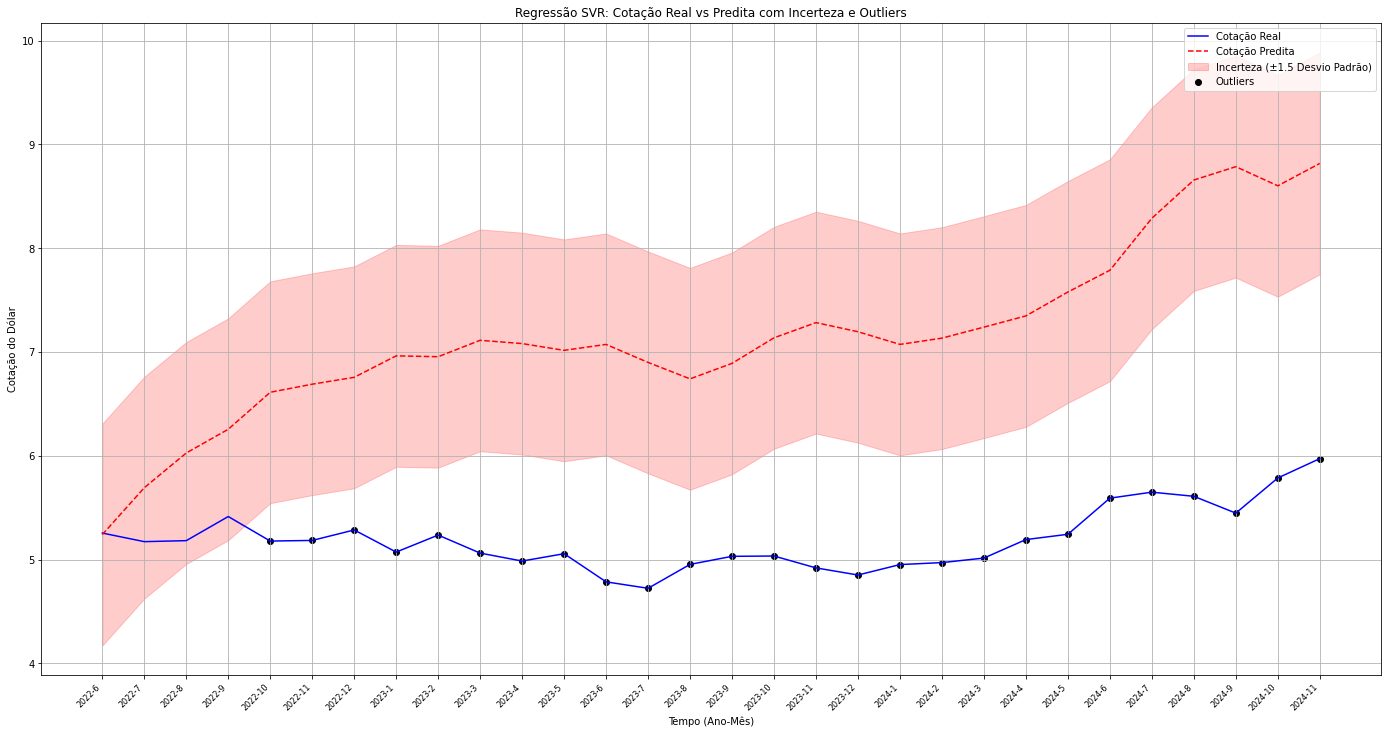

In [21]:
# Definir variáveis preditoras e alvo
X = df.drop(columns=['t', 'ano', 'mes', 'cotacao', 'ipca_acumulado', 'cpi', 'selic',
       'divida_pp', 'fed_rate'])  # Remover colunas irrelevantes
y = df['cotacao']


# Separar treino e teste preservando a ordem temporal (80% treino, 20% teste)
train_size = int(len(df) * 0.90)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Normalizar os dados com MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir o modelo SVR
svr = SVR()

# Definir os hiperparâmetros a serem otimizados
param_grid = {
    'C': (0.1, 1000.0),
    'epsilon': (0.0001, 1.0),
    'gamma': (1e-5, 1.0),
    'kernel': ['rbf', 'poly'] 
}

# Validação cruzada preservando ordem temporal
tscv = TimeSeriesSplit(n_splits=5)

# Otimização Bayesiana com TimeSeriesSplit
bayes_search = BayesSearchCV(
    svr,
    param_grid,
    n_iter=40,  # Número de avaliações
    cv=tscv,  # Mantém a sequência temporal
    scoring='neg_mean_absolute_error',  # Maximizar R²
    n_jobs=-1,
    random_state=42,
    optimizer_kwargs = {'base_estimator': 'GP'}
)

# Treinar o modelo
bayes_search.fit(X_train_scaled, y_train)

# Exibir melhores hiperparâmetros
print("Melhores hiperparâmetros:", bayes_search.best_params_)

# Avaliar no conjunto de teste
best_svr = bayes_search.best_estimator_
y_pred = best_svr.predict(X_test_scaled)

# Calcular erro médio absoluto e R²
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Erro Médio Absoluto no Teste:", mae)
print("R² score:", r2)

# Calcular os resíduos (erro)
residuos = y_test - y_pred

# Calcular o desvio padrão dos resíduos
std_dev = np.std(residuos)

mul_std = 1.5
# Identificar pontos que estão fora da faixa de incerteza
lower_bound = y_pred - mul_std * std_dev
upper_bound = y_pred + mul_std * std_dev
outliers_mask = (y_test.values < lower_bound) | (y_test.values > upper_bound)

# Criar rótulos do eixo X (ano-mês) para o conjunto de teste
x_labels = df.iloc[train_size:][['ano', 'mes']].astype(str).agg('-'.join, axis=1).values

# Criar gráfico de predição vs. real
plt.figure(figsize=(24, 12))
plt.plot(x_labels, y_test.values, label="Cotação Real", color="blue")
plt.plot(x_labels, y_pred, label="Cotação Predita", color="red", linestyle="dashed")

# Adicionar faixa de incerteza
plt.fill_between(x_labels, lower_bound, upper_bound, 
                 color='red', alpha=0.2, label=f"Incerteza (±{mul_std} Desvio Padrão)")

# Plotar os outliers como pontos destacados
plt.scatter(np.array(x_labels)[outliers_mask], y_test.values[outliers_mask], 
            color='black', marker='o', label="Outliers")

# Melhorar legibilidade do eixo X
plt.xticks(rotation=45, ha='right', fontsize=8)

# Configurações do gráfico
plt.xlabel("Tempo (Ano-Mês)")
plt.ylabel("Cotação do Dólar")
plt.title("Regressão SVR: Cotação Real vs Predita com Incerteza e Outliers")
plt.legend()
plt.grid()
plt.show()

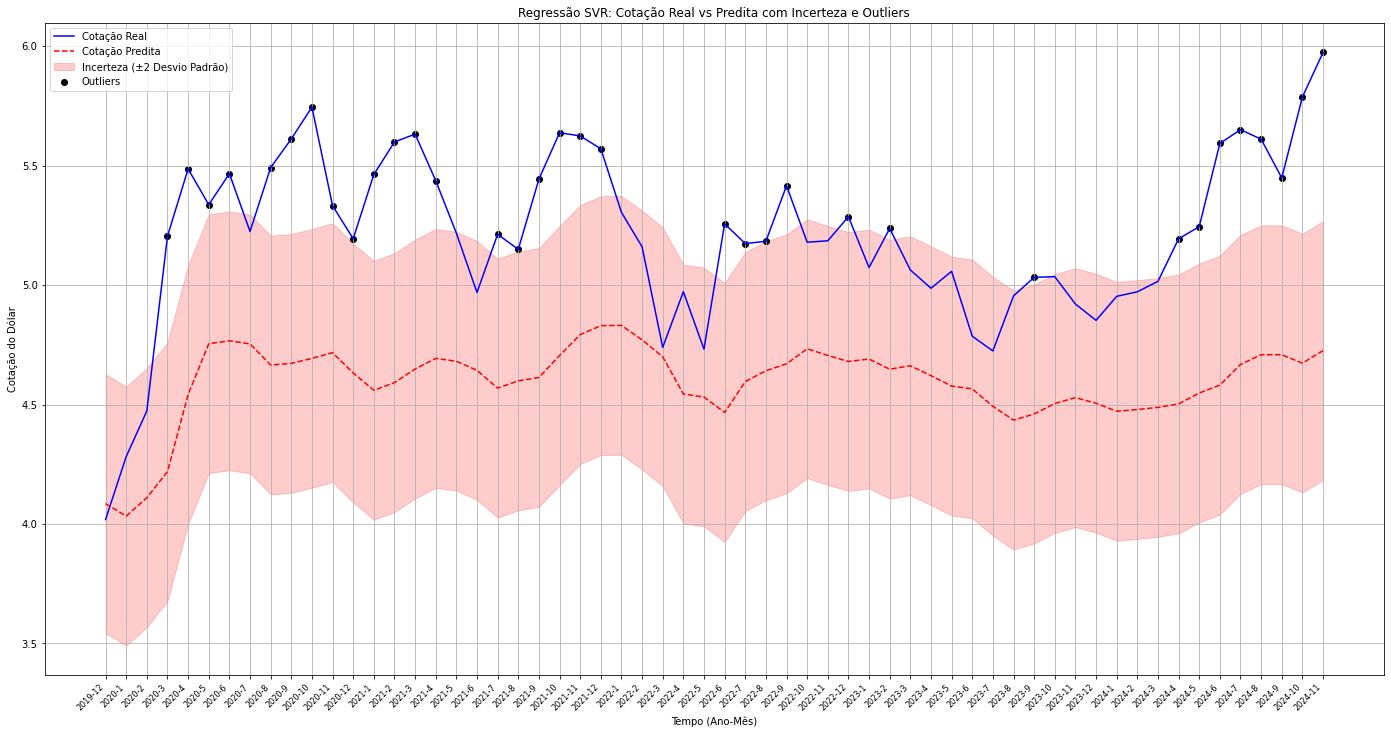

In [19]:
mul_std = 2
# Identificar pontos que estão fora da faixa de incerteza
lower_bound = y_pred - mul_std * std_dev
upper_bound = y_pred + mul_std * std_dev
outliers_mask = (y_test.values < lower_bound) | (y_test.values > upper_bound)

# Criar rótulos do eixo X (ano-mês) para o conjunto de teste
x_labels = df.iloc[train_size:][['ano', 'mes']].astype(str).agg('-'.join, axis=1).values

# Criar gráfico de predição vs. real
plt.figure(figsize=(24, 12))
plt.plot(x_labels, y_test.values, label="Cotação Real", color="blue")
plt.plot(x_labels, y_pred, label="Cotação Predita", color="red", linestyle="dashed")

# Adicionar faixa de incerteza
plt.fill_between(x_labels, lower_bound, upper_bound, 
                 color='red', alpha=0.2, label=f"Incerteza (±{mul_std} Desvio Padrão)")

# Plotar os outliers como pontos destacados
plt.scatter(np.array(x_labels)[outliers_mask], y_test.values[outliers_mask], 
            color='black', marker='o', label="Outliers")

# Melhorar legibilidade do eixo X
plt.xticks(rotation=45, ha='right', fontsize=8)

# Configurações do gráfico
plt.xlabel("Tempo (Ano-Mês)")
plt.ylabel("Cotação do Dólar")
plt.title("Regressão SVR: Cotação Real vs Predita com Incerteza e Outliers")
plt.legend()
plt.grid()
plt.show()

### Dataset Dolar - janela 6 meses

,t,ano,mes,cotacao,ipca_acumulado,cpi,selic,divida_pp,fed_rate,cotacao_1,...,cpi_4,selic_4,divida_pp_4,fed_rate_4,cotacao_5,ipca_acumulado_5,cpi_5,selic_5,divida_pp_5,fed_rate_5
0,1,2000,1,1.7840,9.22,169.300,18.937619,51.27,5.45,1.7840,...,169.300,18.937619,51.27,5.45,1.7840,9.22,169.300,18.937619,51.27,5.45
1,2,2000,2,1.7680,9.35,170.000,18.869524,51.27,5.73,1.7840,...,169.300,18.937619,51.27,5.45,1.7840,9.22,169.300,18.937619,51.27,5.45
2,3,2000,3,1.7395,9.57,171.000,18.846667,51.27,5.85,1.7680,...,169.300,18.937619,51.27,5.45,1.7840,9.22,169.300,18.937619,51.27,5.45
3,4,2000,4,1.8050,9.99,170.900,18.618421,51.27,6.02,1.7395,...,169.300,18.937619,51.27,5.45,1.7840,9.22,169.300,18.937619,51.27,5.45
4,5,2000,5,1.8240,10.00,171.200,18.512727,51.27,6.27,1.8050,...,169.300,18.937619,51.27,5.45,1.7840,9.22,169.300,18.937619,51.27,5.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,295,2024,7,5.6500,157.05,313.534,10.400000,77.44,5.33,5.5925,...,312.230,11.000000,75.09,5.33,4.9716,155.46,311.054,11.150000,74.85,5.33
295,296,2024,8,5.6103,157.03,314.121,10.400000,77.65,5.33,5.6500,...,313.207,10.650000,75.26,5.33,5.0153,155.62,312.230,11.000000,75.09,5.33
296,297,2024,9,5.4482,157.47,314.686,10.495238,77.44,5.13,5.6103,...,313.225,10.459524,75.81,5.33,5.1934,156.00,313.207,10.650000,75.26,5.33
297,298,2024,10,5.7867,158.03,315.454,10.650000,77.75,4.83,5.4482,...,313.049,10.400000,76.85,5.33,5.2443,156.46,313.225,10.459524,75.81,5.33


Melhores hiperparâmetros: OrderedDict({'C': 67.1622960323484, 'epsilon': 0.0004893092827716302, 'gamma': 0.015370658218145738, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.26688154561575916
R² score: 0.11039089393710844


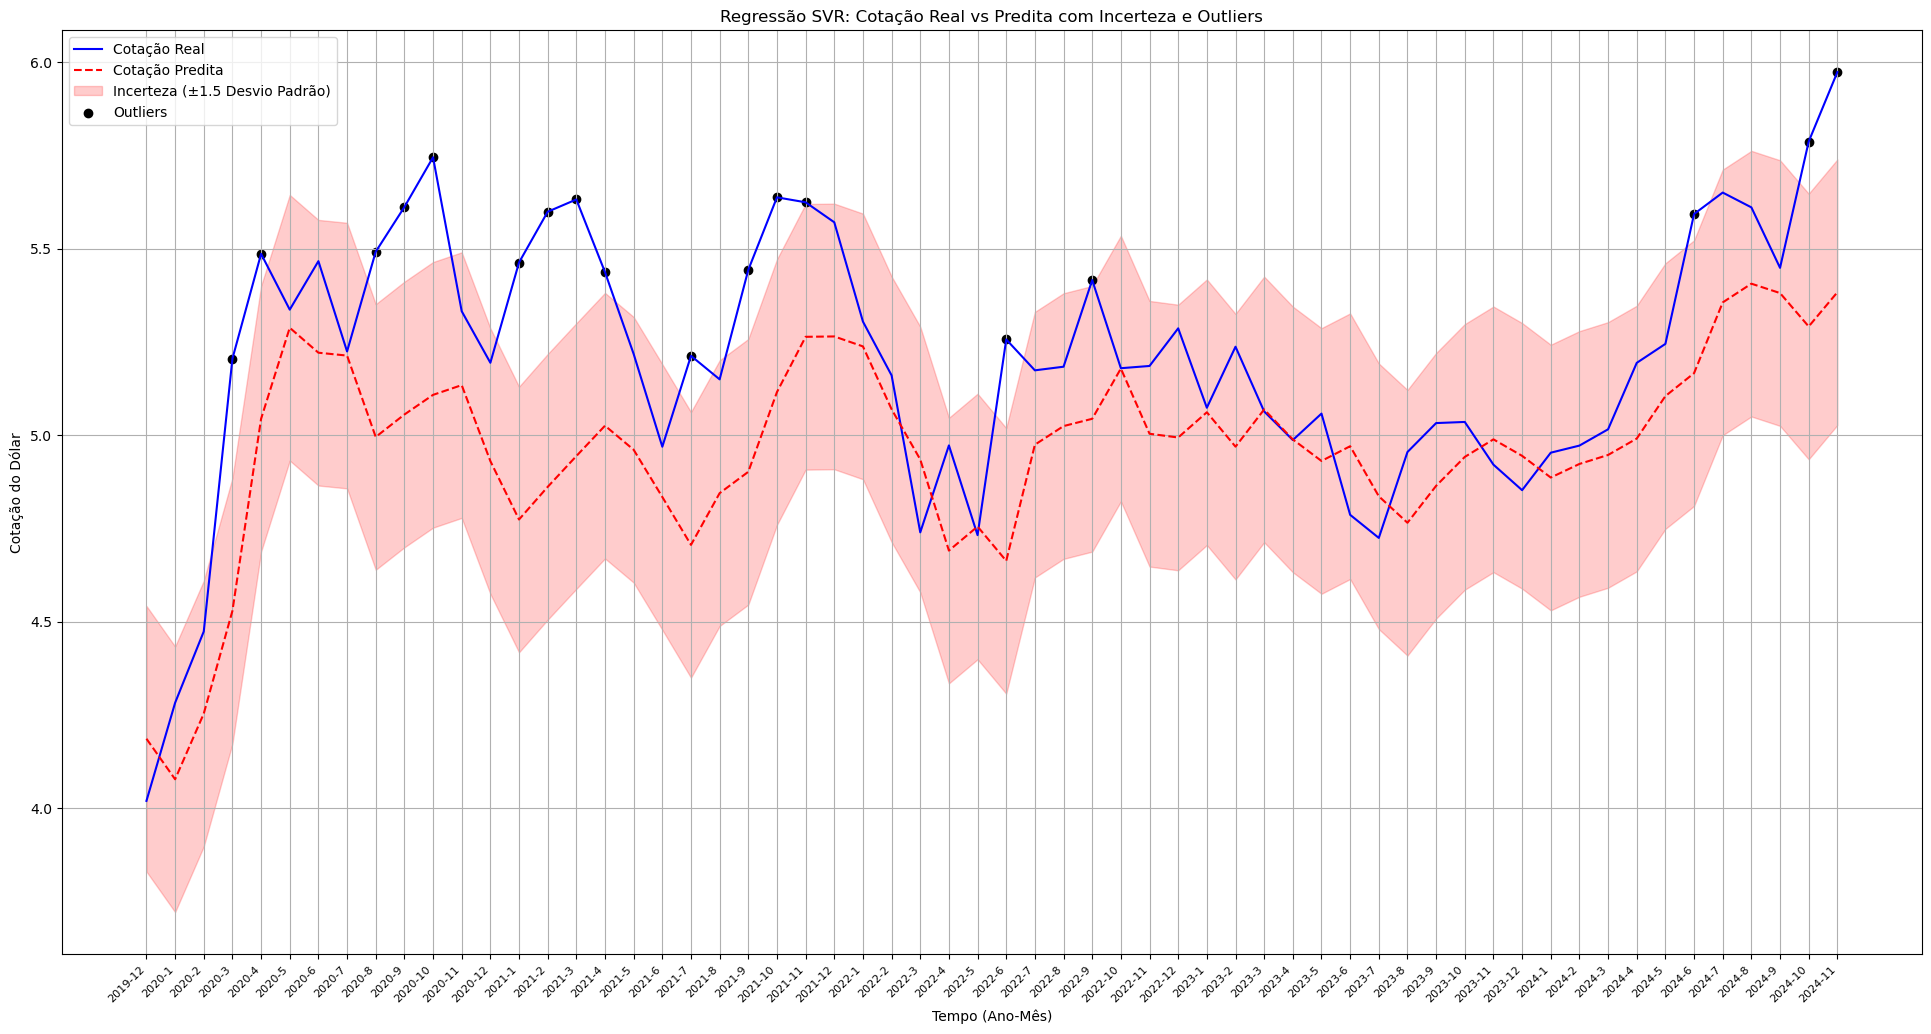

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

# Carregar os dados
file_path = "Dataset_Dolar.csv"
df = pd.read_csv(file_path)

display(df)

# Definir variáveis preditoras e alvo
X = df.drop(columns=['cotacao','t', 'ano', 'mes'])  # Remover colunas irrelevantes
y = df['cotacao']


# Separar treino e teste preservando a ordem temporal (80% treino, 20% teste)
train_size = int(len(df) * 0.80)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Normalizar os dados com MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir o modelo SVR
svr = SVR()

# Definir os hiperparâmetros a serem otimizados
param_grid = {
    'C': (0.1, 1000.0, 'log-uniform'),
    'epsilon': (0.0001, 1.0, 'log-uniform'),
    'gamma': (1e-5, 1.0, 'log-uniform'),
    'kernel': ['rbf', 'poly'] 
}

# Validação cruzada preservando ordem temporal
tscv = TimeSeriesSplit(n_splits=3)

# Otimização Bayesiana com TimeSeriesSplit e métrica R²
bayes_search = BayesSearchCV(
    svr,
    param_grid,
    n_iter=40,  # Número de avaliações, 70
    cv=tscv,  # Mantém a sequência temporal
    scoring='neg_mean_absolute_error',  # Maximizar R²
    n_jobs=-1,
    random_state=42
)

# Treinar o modelo
bayes_search.fit(X_train_scaled, y_train)

# Exibir melhores hiperparâmetros
print("Melhores hiperparâmetros:", bayes_search.best_params_)

# Avaliar no conjunto de teste
best_svr = bayes_search.best_estimator_
y_pred = best_svr.predict(X_test_scaled)

# Calcular erro médio absoluto e R²
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Erro Médio Absoluto no Teste:", mae)
print("R² score:", r2)

# Calcular os resíduos (erro)
residuos = y_test - y_pred

# Calcular o desvio padrão dos resíduos
std_dev = np.std(residuos)
mul_std = 1.5
# Identificar pontos que estão fora da faixa de incerteza
lower_bound = y_pred - mul_std * std_dev
upper_bound = y_pred + mul_std * std_dev
outliers_mask = (y_test.values < lower_bound) | (y_test.values > upper_bound)

# Criar rótulos do eixo X (ano-mês) para o conjunto de teste
x_labels = df.iloc[train_size:][['ano', 'mes']].astype(str).agg('-'.join, axis=1).values

# Criar gráfico de predição vs. real
plt.figure(figsize=(24, 12))
plt.plot(x_labels, y_test.values, label="Cotação Real", color="blue")
plt.plot(x_labels, y_pred, label="Cotação Predita", color="red", linestyle="dashed")

# Adicionar faixa de incerteza
plt.fill_between(x_labels, lower_bound, upper_bound, 
                 color='red', alpha=0.2, label=f"Incerteza (±{mul_std} Desvio Padrão)")

# Plotar os outliers como pontos destacados
plt.scatter(np.array(x_labels)[outliers_mask], y_test.values[outliers_mask], 
            color='black', marker='o', label="Outliers")

# Melhorar legibilidade do eixo X
plt.xticks(rotation=45, ha='right', fontsize=8)

# Configurações do gráfico
plt.xlabel("Tempo (Ano-Mês)")
plt.ylabel("Cotação do Dólar")
plt.title("Regressão SVR: Cotação Real vs Predita com Incerteza e Outliers")
plt.legend()
plt.grid()
plt.show()

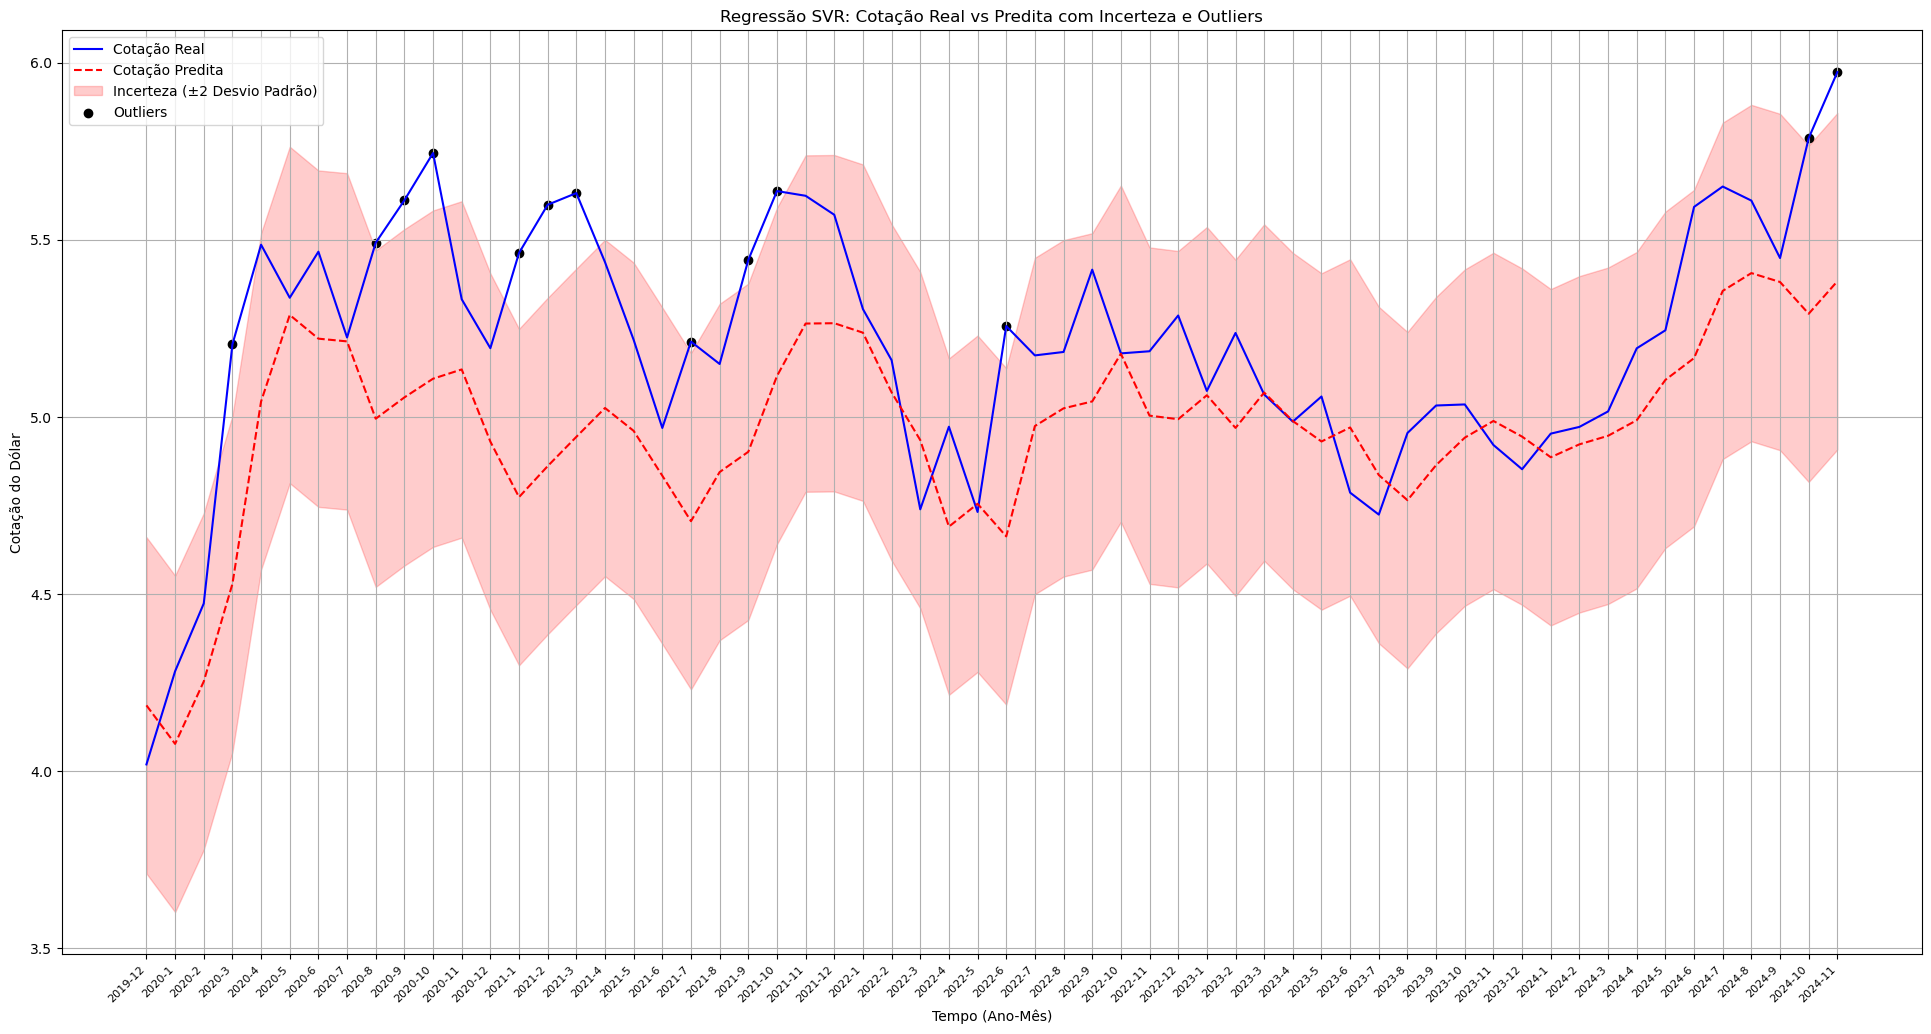

In [6]:
mul_std = 2
# Identificar pontos que estão fora da faixa de incerteza
lower_bound = y_pred - mul_std * std_dev
upper_bound = y_pred + mul_std * std_dev
outliers_mask = (y_test.values < lower_bound) | (y_test.values > upper_bound)

# Criar rótulos do eixo X (ano-mês) para o conjunto de teste
x_labels = df.iloc[train_size:][['ano', 'mes']].astype(str).agg('-'.join, axis=1).values

# Criar gráfico de predição vs. real
plt.figure(figsize=(24, 12))
plt.plot(x_labels, y_test.values, label="Cotação Real", color="blue")
plt.plot(x_labels, y_pred, label="Cotação Predita", color="red", linestyle="dashed")

# Adicionar faixa de incerteza
plt.fill_between(x_labels, lower_bound, upper_bound, 
                 color='red', alpha=0.2, label=f"Incerteza (±{mul_std} Desvio Padrão)")

# Plotar os outliers como pontos destacados
plt.scatter(np.array(x_labels)[outliers_mask], y_test.values[outliers_mask], 
            color='black', marker='o', label="Outliers")

# Melhorar legibilidade do eixo X
plt.xticks(rotation=45, ha='right', fontsize=8)

# Configurações do gráfico
plt.xlabel("Tempo (Ano-Mês)")
plt.ylabel("Cotação do Dólar")
plt.title("Regressão SVR: Cotação Real vs Predita com Incerteza e Outliers")
plt.legend()
plt.grid()
plt.show()